# Building a map from distances between cities

Let's say we know the distances between several cities and want to place them on a map. Python and `scipy.optimize` offer everything to plot the cities properly. You may appreciate to read more about gradient descent, line search, or conjugate gradient. [This website](http://www.benfrederickson.com/numerical-optimization/) is a good reference (with nice Javascript animations!).


In [ ]:
import numpy as np

In [2]:
cities = """
Amsterdam Athens    Barcelona Berlin   Bucarest  Budapest Brussels Copenhagen
Dublin    Edinburgh Gibraltar Helsinki Istanbul  Kiev     Lisbon   London
Madrid    Milan     Moscow    Munich   Nantes    Oslo     Paris    Prague
Reykjavik Riga      Rome      Sofia    Stockholm Toulouse Vilnius  Warsaw
"""

cities = cities.split()
n = len(cities) # 32

We can load the distances between cities from the following file:

In [3]:
distances = np.load("data/cities_distances.npy")

In [4]:
distances

array([[ 0.        ,  0.03414099,  0.0165491 , ...,  0.01377416,
         0.02987646,  0.02347701],
       [ 0.03414099,  0.        ,  0.03176593, ...,  0.03342599,
         0.02238825,  0.0197085 ],
       [ 0.0165491 ,  0.03176593,  0.        , ...,  0.00342029,
         0.03854892,  0.03150981],
       ..., 
       [ 0.01377416,  0.03342599,  0.00342029, ...,  0.        ,
         0.03809453,  0.03105398],
       [ 0.02987646,  0.02238825,  0.03854892, ...,  0.03809453,
         0.        ,  0.0070488 ],
       [ 0.02347701,  0.0197085 ,  0.03150981, ...,  0.03105398,
         0.0070488 ,  0.        ]])

## The optimisation problem

We consider a matrix of distances separating cities in Europe. We want to find they $(x,y)$-positions on a map such that all distances are respected.

This corresponds to minimising the sum

$$f\left(x_0, y_0, \cdots, y_n\right) =\sum_i\sum_j \left(\left(x_i - x_j\right)^2 + \left(y_i - y_j\right)^2 - d_{i, j}^2\right)^2$$

With 32 cities, that is a problem of 64 floating precision variables we can solve with many optimisation methods embedded in `scipy.optimize`.  
We choose here `fmin_bfgs` (for Broyden-Fletcher-Goldfarb-Shanno), that takes the function to minimise and its derivate. 

In [5]:
def func(*x):
    """ Compute the function to minimise.
    
    Vector reshaped for more readability.
    """
    res = 0
    x = np.array(x)
    x = x.reshape((n, 2))
    for i in range(n):
        for j in range(i+1, n):
            (x1, y1), (x2, y2) = x[i, :], x[j, :]
            delta = (x2 - x1)**2 + (y2 - y1)**2 - distances[i, j]**2
            res += delta**2
    return res

def func_der(*x):
    """ Derivative of the preceding function.
    
    Note: (f \circ g)' = g' \times f' \circ g
    Vector reshaped for more readability.
    """
    res = np.zeros((n, 2))
    x = np.array(x)
    x = x.reshape((n, 2))
    for i in range(n):
        for j in range(i+1, n):
            (x1, y1), (x2, y2) = x[i, :], x[j, :]
            delta = (x2 - x1)**2 + (y2 - y1)**2 - distances[i, j]**2
            res[i, 0] += 4 * (x1 - x2) * delta
            res[i, 1] += 4 * (y1 - y2) * delta
            res[j, 0] += 4 * (x2 - x1) * delta
            res[j, 1] += 4 * (y2 - y1) * delta
    return np.ravel(res)

Before we can call the BFGS algorithm, we need to compute an initial state. We use here a normal law but as we will want to plot the full convergence process later, we choose to scale the initial distribution of points with the norm of the distance matrix.

In [6]:
import numpy.linalg as la

# initial random position
x0 = np.random.normal(size=(n, 2))

# normalize initial position so as to not look too stupid from start
l1, l2 = np.meshgrid(x0[:,0], x0[:,0])
r1, r2 = np.meshgrid(x0[:,1], x0[:,1])
x0 /= la.norm(np.sqrt((l1 - l2)**2 + (r1 - r2)**2))

So now we are ready!

In [7]:
import scipy.optimize as sopt
solution = sopt.fmin_bfgs(func, x0, fprime=func_der, retall=True)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


## Post-processing the solution

Now we have a solution (which looks quite good!), and thanks to the `retall` parameter, we get the full convergence track in the second argument of the tuple.

Yet, since all rotations of maps and mirrors of solution maps are equivalent solutions to our problem (we call these symmetries), we need to do some post-processing to put the map in a familiar way:
- we can use the fact that Rome and Copenhagen are almost aligned to rotate the map;
- we take two cities that we know are east/west of each other, and decide whether a mirroring is necessary.

In [8]:
res = solution[0].reshape((n, 2))

# rotate it so that Copenhagen is above Rome
south, north = cities.index("Rome"), cities.index("Copenhagen")
d = res[north, :] - res[south, :]
rotate = np.arctan2(d[1], d[0]) - np.pi/2
mat_rotate = np.array([[np.cos(rotate), -np.sin(rotate)],
                       [np.sin(rotate), np.cos(rotate)]])
res = res @ mat_rotate  # matrix product, from Python 3.5

# mirror so that Reykjavik is west of Moscow
west, east = cities.index("Reykjavik"), cities.index("Moscow")
mirror = False
if res[west, 0] > res[east, 0]:
    mirror = True
    res[:, 0] *= -1

# apply the transformation to the full track 
track = [p.reshape((n, 2)) @ mat_rotate for p in solution[1]]
if mirror == True:
    track = [p * np.array([-1, 1]) for p in track]

And now we can plot all cities coordinates with the track of convergence of their respective positions.

We manually set different parameters:
- we trim the image 10% outside the square hull of the cities' positions;
- we use colormaps to put some sense in this spaghetti soup;
- we manually chose label placements so as to avoid overlaps and improve readability.

Note that this last item could be subject to automatic optimisation.

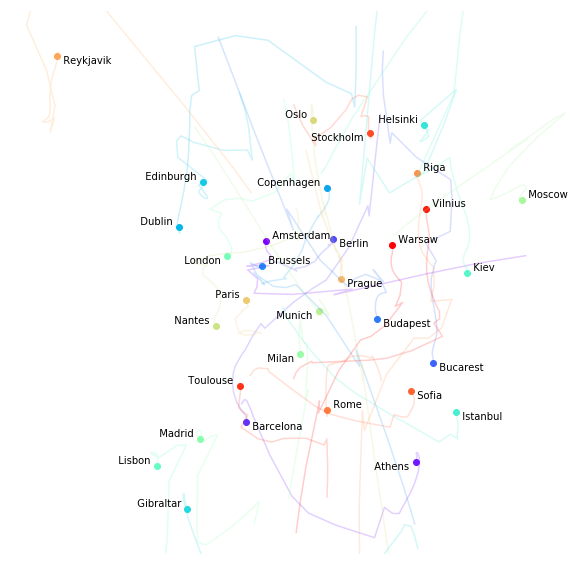

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fig = plt.figure()
fig.set_size_inches(10, 10)

ax = fig.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_axis_off()

# Trimming the final image

bx = min(res[:, 0]), max(res[:, 0])
dx = bx[1] - bx[0]
ax.set_xlim(bx[0] - .1*dx, bx[1] + .1*dx)

by = min(res[:, 1]), max(res[:, 1])
dy = by[1] - by[0]
ax.set_ylim(by[0] - .1*dy, by[1] + .1*dy)

# label placement: subject to automatic optimization!
from collections import defaultdict
d = defaultdict(lambda: {'ha': "left", 'va': "bottom"})

for city in ["Barcelona", "Berlin", "Bucarest", "Budapest",
             "Istanbul", "Prague", "Reykjavik", "Sofia", ]:
    d[city] = {'ha': "left", 'va': "top"}
for city in ["Athens", "London", "Munich",  "Milan",
             "Stockholm", ]:
    d[city] = {'ha': "right", 'va': "top"}
for city in ["Copenhagen", "Dublin", "Edinburgh", "Gibraltar",
             "Helsinki", "Lisbon", "Madrid", "Nantes", "Oslo",
             "Paris", "Toulouse", ]:
    d[city] = {'ha': "right", 'va': "bottom"}
    
# automatic colouring
colors = cm.rainbow(np.linspace(0, 1, n))
    
for i, ((x, y), city, color) in enumerate(zip(res, cities, colors)):
    t = np.array([t[i, :] for t in track])
    ax.plot(t[:, 0], t[:, 1], color=color, alpha=.2)
    ax.scatter(x, y, color=color)
    ax.annotate("  " + city + "  ", (x, y), **d[city])

We can even build a nice animation!

In [10]:
from matplotlib import animation

def anim_to_html(anim):
    plt.close(anim._fig)
    return anim.to_html5_video()

animation.Animation._repr_html_ = anim_to_html

fig = plt.figure(figsize=(10, 10))

ax = fig.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_axis_off()

ax.set_xlim(bx[0] - .1*dx, bx[1] + .1*dx)
ax.set_ylim(by[0] - .1*dy, by[1] + .1*dy)

# automatic colouring
colors = plt.cm.rainbow(np.linspace(0, 1, n))
  
p = {}
s = {}
a = {}

tmax = 1
    
for i, ((x, y), city, color) in enumerate(zip(res, cities, colors)):
    t = np.array([t[i, :] for t in track])
    p[i], = ax.plot(t[:tmax, 0], t[:tmax, 1], color=color, alpha=.2)
    s[i], = ax.plot(t[tmax-1, 0], t[tmax-1, 1], 'o', color=color)
    a[i] = ax.annotate("  " + city + "  ", (t[tmax-1, 0], t[tmax-1, 1]), **d[city])
    
def init():
    return (*p, *s, *a)
    
def update(tmax) :
    for i, ((x, y), city, color) in enumerate(zip(res, cities, colors)):
        t = np.array([t[i, :] for t in track])
        p[i].set_data(t[:tmax, 0], t[:tmax, 1])
        s[i].set_data(t[tmax-1, 0], t[tmax-1, 1])
        a[i].set_position((t[tmax-1, 0], t[tmax-1, 1]))
    return (*p, *s, *a)
    
animation.FuncAnimation(fig, update, len(track), init_func=init, interval=100)

